In [308]:
from graph_tool.generation import *
from graph_tool.correlations import *
from graph_tool.stats import *
from graph_tool.draw import graph_draw, fruchterman_reingold_layout, sfdp_layout, draw_hierarchy
from graph_tool.collection import *
from graph_tool.topology import *
from graph_tool.inference import *
from graph_tool.spectral import *
import numpy as np
import matplotlib.pyplot as plt

In [296]:
# number of nodes
N = int(1e3)

# hospital layer size
fhosp = 0.02
Nhosp = int(fhosp*N)

# health care workers
fhealth = 0.03
Nhealth = int(fhealth*N)

# city layer size
Ncity = N-Nhosp-Nhealth

number nodes 20
number edges 47


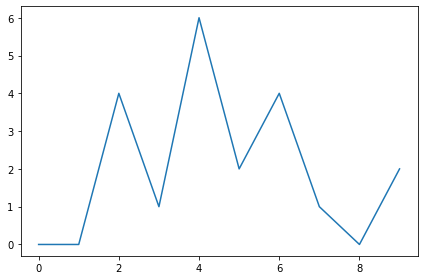

In [297]:
n = Nhosp
p = 5/Nhosp
m = int(p*Nhosp*(Nhosp-1)/2)

print("number nodes", n)
print("number edges", m)

ak = np.floor(2 * m / n)
dm = 2 * m - ak * n

ER = random_graph(n, lambda i: ak + 1 if i < dm else ak, directed=False, random=False) 

ret = random_rewire(ER, 'erdos', n_iter = 1)

degree_hist = vertex_hist(ER, "total")

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.tight_layout()

plt.show()

number nodes 30
number edges 217


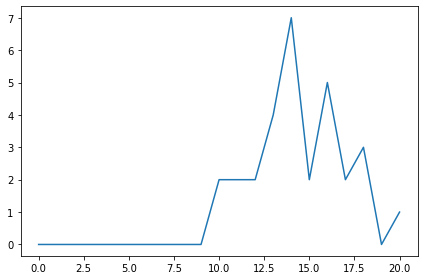

In [298]:
n2 = Nhealth
p2 = 15/Nhealth
m2 = int(p2*Nhealth*(Nhealth-1)/2)

print("number nodes", n2)
print("number edges", m2)

ak2 = np.floor(2 * m2 / n2)
dm2 = 2 * m2 - ak2 * n2

ER2 = random_graph(n2, lambda i: ak2 + 1 if i < dm2 else ak2, directed=False, random=False) 

ret = random_rewire(ER2, 'erdos', n_iter = 1)

degree_hist = vertex_hist(ER2, "total")

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.tight_layout()

plt.show()

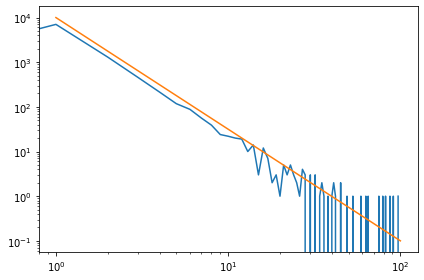

In [282]:
def sample_k(max):

    accept = False

    while not accept:

        k = np.random.randint(1,max+1)

        accept = np.random.random() < 1.0/k**2.5

    return k

SF = random_graph(Ncity, lambda: sample_k(100), directed=False, model = 'configuration', n_iter=100)

degree_hist = vertex_hist(SF, "total")

xx = np.linspace(1, 100)

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.plot(xx, 1e4*xx**-2.5)

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

plt.show()

20


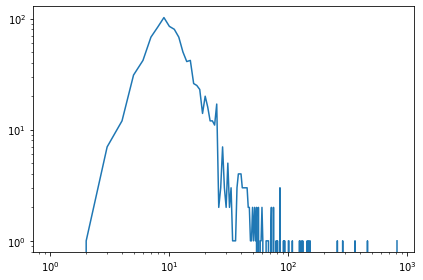

In [299]:
# generate SBM

ER_out = ER.get_out_degrees(ER.get_vertices())

ER2_out = ER.get_out_degrees(ER.get_vertices())

SF_out = SF.get_out_degrees(SF.get_vertices())

groups = np.asarray(Nhosp*[0]+Nhealth*[1]+Ncity*[2])

in_d = np.append(ER_out,ER2_out)
in_d = np.append(in_d,SF_out)

out_d = np.append(ER_out,ER2_out)
out_d = np.append(out_d,SF_out)

pmatrix = np.asarray([[Nhosp*5,Nhosp*5,0],[Nhosp*5,Nhealth*10,Nhealth*5],[0,Nhealth*5,Ncity*10*np.mean(SF_out)]])

print(Nhosp)
u = generate_sbm(groups, pmatrix, in_degs = in_d, out_degs = out_d, directed = False)

degree_hist = vertex_hist(u, "total")

#print(degree_hist[1][:-1], degree_hist[0])

plt.figure()

plt.plot(degree_hist[1][:-1], degree_hist[0])

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.show()

# Extract the largest component
largest_comp = GraphView(u, vfilt = label_largest_component(u))

A = adjacency(largest_comp)

Mc=A.tocoo()

np.savetxt('edge_list_SBM_1e4.txt', np.c_[Mc.row,Mc.col], fmt = '%d %d', header = 'hosp nodes 0-%d, health care worker nodes %d-%d, remaining nodes belong to city'%(Nhosp-1,Nhosp,Nhosp+Nhealth-1))

In [309]:
#state = minimize_blockmodel_dl(largest_comp, deg_corr=False)

state = minimize_nested_blockmodel_dl(largest_comp, deg_corr=True)

draw_hierarchy(state, output="graph_nested.png")

v_size=largest_comp.get_out_degrees(largest_comp.get_vertices())

deg = largest_comp.degree_property_map("out")

p = fruchterman_reingold_layout(largest_comp, n_iter=1000)

#state.draw(output="graph2.png")

graph_draw(largest_comp, pos = p, vertex_size = deg, output="graph.png")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb43a912820, at 0x7fb430617850>